<div class="alert alert-success" style = "border-radius:50px;text-align: center; color: blue" role="alert">
    Please hit the UPVOTE button! if you liked my notebook. and I'll follow you.
</div>

# Langchain Tutorial CustomLLM for Llama2
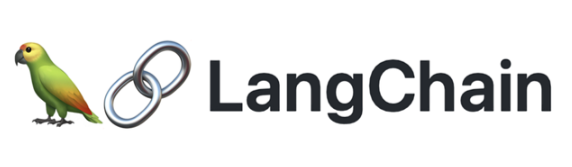

I've already written a tutorial on the basic functions. 
[LLM Langchain Tutorial basic function (eng)](https://www.kaggle.com/code/kimhyeongjun0/llm-langchain-tutorial-basic-function-eng)

This time, what I've prepared is that Langchain is not limited to using only OpenAI's GPT series as a library.
 
Apart from GPT, llama2 and mistral are among the most commonly used LLMs. To use such models with Langchain, they need to be separately imported.

You can operate them using transformers. Since Langchain supports its own HuggingFacePipline, by setting up a pipeline for text generation, you can also use HuggingFace models by replacing the llm part from OpenAI.

By configuring it through this pipeline, there's a downside of not being able to utilize callbacks or streaming functionalities. 

Additionally, for methods like quantum models that aren't integrated into HuggingFace Transformers, such as CPP implementation, exllama, or AWQ, they are currently not supported through the HuggingFace pipeline, making them inaccessible. 

For now, I'll explain the process of first using the HuggingFace pipeline and then creating a custom LLM according to your needs.

기본 펑션에 대한 튜토리얼은 이미 작성을 하였습니다.[LLM Langchain Tutorial basic function (eng)](https://www.kaggle.com/code/kimhyeongjun0/llm-langchain-tutorial-basic-function-eng)
 이번에 준비한 내용은, 랭체인은 Openai의 gpt 시리즈만 사용 가능한 라이브러리가 아닙니다. gpt 이외에 가장 많이 사용되는 LLM으로서는 llama2와 mistral이 대표적으로 가장 많이 사용되고 있습니다. 이와 같은 모델들을 랭체인과 함께 사용하기 위해서 따로 불러올 필요가 있습니다. transformers를 이용해서 구동 시킬 수 있습니다. 랭체인에서 자체적으로 HuggingFacePipline을 지원해주기 때문에 Text 생성에 대한 파이프라인만 구성해주면 허깅페이스 모델도 llm 부분을 OpenAI에서 교체해서 사용할 수 있다.  이렇게 파이프라인을 통해서 구성하게 되면, 라는 callback이나 stream 기능 등등을 사용하지 못하는 아쉬운 점이 있다.그 외에도 양자화 모델을 사용할때 허깅페이스 트랜스포머스에 통합되지 않은 방식들의 경우, CPP구현이나 exllama, AWQ 같은 경우는 허깅페이스파이프라인 으로 아직 지원하지 않으니 사용이 불가능하다. 일단, 허깅페이스파이프라인을 먼저 사용해보고, 자신에 맞게끔 커스텀 LLM을 만드는 과정을 설명하겠습니다. 

**IMPORT & SETUP**

In [2]:
!pip install --quiet langchain
!pip install --quiet langchain_experimental
!pip install --quiet openai
!pip install --quiet tiktoken
!pip install --quiet sentence-transformers
!pip install --quiet pypdf
!pip install --quiet faiss-cpu
!pip install -q -U peft accelerate
!pip install --quiet auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu117/
!pip install --quiet git+https://github.com/huggingface/optimum.git
!pip install --quiet git+https://github.com/huggingface/transformers.git
!pip install --quiet bitsandbytes
!pip install --quiet jsonformer

In [3]:
import json
import torch
import jsonformer

from functools import partial
from threading import Thread
from typing import List, Mapping, Optional, Any, Dict
from pydantic import BaseModel, Field, validator

from langchain import HuggingFacePipeline
from langchain import PromptTemplate
from langchain.schema import BaseOutputParser
from langchain.llms.base import LLM
from langchain.llms.utils import enforce_stop_tokens
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.output_parsers import PydanticOutputParser,OutputFixingParser,RetryWithErrorOutputParser
from langchain.output_parsers.format_instructions import PYDANTIC_FORMAT_INSTRUCTIONS
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline, TextStreamer, TextIteratorStreamer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# HuggingFace Pipline

When using the HuggingFace pipeline in Langchain, it becomes straightforward to utilize HuggingFace models.

Simply define the model, tokenizer, and generation_config, and they become usable in Langchain through the pipeline approach.

랭체인에서 허깅페이스 파이프라인을 이용하면 쉽게 허깅페이스 모델들을 사용할 수 있습니다. model과 tokenizer, generation_config만 정의 해주면 파이프라인 방식으로 랭체인에서 사용가능합니다. 

In [ ]:
# model_name = "facebook/opt-125m"
model_name = "TheBloke/Llama-2-13b-Chat-GPTQ"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.float16,
                                             trust_remote_code=True,
                                             device_map="auto"
                                             )


generation_config = GenerationConfig.from_pretrained(model_name)
generation_config.max_new_tokens = 256
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config,
)

llm = HuggingFacePipeline(model_id = model_name, pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [4]:
template = """[INST] <<SYS>>
<</SYS>>

{text}[/INST]"""

llama_prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

prompt_and_model = llama_prompt | llm
text = "Tell me a joke."

print(prompt_and_model.invoke({"text" : text}))

  Sure, here's one:

Why couldn't the bicycle stand up by itself?

Because it was two-tired!


## Function Calling / Json

Unlike in OpenAI's GPT, other LLMs don't support function calling.

Even when using the HuggingFace pipeline, explicitly specifying such formats in the prompt often leads to frequent failures in functioning properly.

I'll explore the method of crafting a custom LLM by examining instances where it doesn't work as a means to address these issues.

OpenAI의 GPT와 달리 다른 LLM에서는 Function calling 기능을 사용 할 수 없습니다. 허깅페이스 파이프라인을 사용하더라도 명시적으로 이러한 형식으로 생성해달라고 프롬프트에 작성해놨어도 제대로 작동 안하는 경우가 많이 발생합니다. 안되는 경우를 보고 customLLM을 작성하는 방법을 알아보겠습니다. 

In [5]:
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")
    
parser = PydanticOutputParser(pydantic_object=Joke)

In [6]:
template = """[INST] <<SYS>>
{format_instructions}

<</SYS>>
{text}[/INST]"""

llama_prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

In [7]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}
```


In [8]:
llama_prompt.format(text="Tell me a joke.")

'[INST] <<SYS>>\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}\n```\n\n<</SYS>>\nTell me a joke.[/INST]'

In [9]:
prompt_and_model = llama_prompt | llm
text = "Tell me a joke."

print(prompt_and_model.invoke({"text" : text}))

  Sure! Here's one:

What do you call a fake noodle?

(Note: This is just a setup question - I'll need your answer to complete the joke!)


# Custom TransformersLLM

To create a CustomLLM, you can inherit from langchain.llms.base's LLM, enabling seamless generation if you receive the generated text in the call section. 

Let's implement this using transformers, the most straightforward approach. 

I'll incorporate several functionalities to replace the HuggingFace pipeline. 

I'll attempt to modify it to allow for streaming token generation. 

To enable streaming tokens, you can create a generator using TextIteratorStreamer to output tokens one by one.

Similarly, we can create mechanisms to run other models. Using LLM execution libraries like AWQ, Exllama, VLLM, we can build custom functionalities according to our requirements.

CustomLLM을 만들기 위해서는 langchain.llms.base의 LLM을 상속받아서 만들 수 있습니다. 상속받아서 call부분에 생성되는 텍스트를 받는다면 문제없이 생성이 가능합니다. 가장 쉽게 구현가능한 transformers를 이용해서 구현을 해봅니다. 허깅페이스 파이프라인을 대체 하는 기능을 몇몇개 넣어보겠습니다. streaming token 생성 방식이 가능하게끔 수정해보겠습니다. 스트리밍 토큰이 가능하려면 TextIteratorStreamer을 통해 generator를 만들어서 토큰 하나 하나씩 출력하는 방법을 사용하면 됩니다.이와 비슷하게 다른 모델들을 구동시키는 것을 만들 수 있습니다. AWQ나 Exllama, VLLM같은 LLM 구동라이브러리를 사용해서 만들 수 있고, 원하는 기능을 추가 할 수 있습니다.

In [4]:
class TransformersLLM(LLM):

    model_folder_path: str = Field(None, alias='model_folder_path')
    model_name: str = Field(None, alias='model_name')
    backend: Optional[str] = 'llama'
    temperature: Optional[float] = 0.7
    top_p: Optional[float] = 0.1
    top_k: Optional[int] = 40
    max_tokens: Optional[int] = 200
    repetition_penalty: Optional[float] = 1.15
    ## 추가 ##
    model: Any = None
    tokenizer: Any = None
    #########

    def __init__(self, model_folder_path, callbacks=None, **kwargs):
        super(TransformersLLM, self).__init__()
        self.model_folder_path: str = model_folder_path
        self.callbacks = callbacks
        ## 추가 ##
        self.model = AutoModelForCausalLM.from_pretrained(self.model_folder_path,
                                                          torch_dtype=torch.float16,
                                                          trust_remote_code=True, #13B True
                                                          do_sample=True,
                                                          device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_folder_path, use_fast=False)
        #########


    @property
    def _get_model_default_parameters(self):
        return {
            "max_tokens": self.max_tokens,
            "temperature": self.temperature,
            "repetition_penalty" : self.repetition_penalty,
        }

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {
            'model_name': self.model_name,
            'model_path': self.model_folder_path,
            'model_parameters': self._get_model_default_parameters
        }

    @property
    def _llm_type(self) -> str:
        return 'llama'

    def _call(self,
              prompt: str,
              stop: Optional[List[str]] = None,
              run_manager: Optional[CallbackManagerForLLMRun] = None,
              stream=False,
              **kwargs) -> str:

        params = {
            **self._get_model_default_parameters,
            **kwargs
        }

        text_callback = None
        if run_manager:
            text_callback = partial(run_manager.on_llm_new_token, verbose=self.verbose)

        ## 추가 ##               
        input_ids = self.tokenizer(prompt, max_length=4096, truncation=True, return_tensors='pt').input_ids.cuda()
        
        if stream is True:
            streamer = TextIteratorStreamer(self.tokenizer, skip_prompt=True, skip_special_tokens=True)
            generate_kwargs = dict(input_ids=input_ids,
                                   max_new_tokens=params['max_tokens'],
                                   temperature=params['temperature'],
                                   repetition_penalty=params['repetition_penalty'],
                                   do_sample=True,
                                   streamer=streamer)

            t = Thread(target=self.model.generate, kwargs=generate_kwargs)
            t.start()

            # token별 스트리밍 생성해서, callback을 사용할 수 있게 수정
            response = ""
            for i, new_text in enumerate(streamer):
                if text_callback:
                    text_callback(new_text)
                response += new_text
                
                # end조건문
                if response.endswith(new_text * 5) and (new_text != ""):
                    break

        if stop:
            response = enforce_stop_tokens(response, stop)
        #########
        return response.strip()

In [ ]:
model_name = "TheBloke/Llama-2-13b-Chat-GPTQ"
llm = TransformersLLM(model_name, callbacks=([StreamingStdOutCallbackHandler()]))

In [6]:
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")
    
parser = PydanticOutputParser(pydantic_object=Joke)

In [7]:
template = """[INST] <<SYS>>
{format_instructions}
<</SYS>>

{text}[/INST]"""

llama_prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

In [8]:
prompt = llama_prompt.format(text="Tell me a joke.")
prompt

'[INST] <<SYS>>\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}\n```\n<</SYS>>\n\nTell me a joke.[/INST]'

In [9]:
llm(prompt, stream=True)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1554: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Sure! Here's one:

Why couldn't the bicycle stand up by itself?

(Note: This is just a setup question - I'll need you to provide the punchline later.)

"Sure! Here's one:\n\nWhy couldn't the bicycle stand up by itself?\n\n(Note: This is just a setup question - I'll need you to provide the punchline later.)"

# Custom JSONformersLLM

Now that I've learned how to create a custom LLM, I want to apply this knowledge to create an LLM that mimics function calling using jsonformers. 

By utilizing parser, Pydantic-created classes, and parser.pydantic_object.schema(), creating a json_schema becomes straightforward.

By providing the required arguments and schema to jsonformers, it's possible to enable function calling-like functionalities in Langchain and llama2.

이번에는 커스텀으로 LLM을 만드는 방법을 알았으니 응용하기위해서 jsonformers를 이용해서 function calling을 흉내내는 LLM을 만들어볼려고합니다. parser와 pydantic을 이용해서 만든 클래스와 parser.pydantic_object.schema()을 사용해서 쉽게 json_schema를 만들 수 있습니다. jsonformers에 원하는 생성에 필요한 인자와 스키마를 제공해주면 function calling과 유사한 기능을 랭체인과 llama2에서 수행하게 할 수 있습니다.  

In [10]:
class JSONformersLLM(LLM):

    model_folder_path: str = Field(None, alias='model_folder_path')
    model_name: str = Field(None, alias='model_name')
    backend: Optional[str] = 'llama'
    temperature: Optional[float] = 0.7
    top_p: Optional[float] = 0.1
    top_k: Optional[int] = 40
    max_tokens: Optional[int] = 200
    repetition_penalty: Optional[float] = 1.15
    ## 추가 ##
    model: Any = None
    tokenizer: Any = None
    #########

    def __init__(self, model_folder_path, callbacks=None, **kwargs):
        super(JSONformersLLM, self).__init__()
        self.model_folder_path: str = model_folder_path
        self.callbacks = callbacks
        
        ## 추가 ##
        self.model = AutoModelForCausalLM.from_pretrained(self.model_folder_path,
                                                          torch_dtype=torch.float16,
                                                          trust_remote_code=True,
                                                          do_sample=True,
                                                          device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_folder_path, use_fast=False)
        #########


    @property
    def _get_model_default_parameters(self):
        return {
            "max_tokens": self.max_tokens,
            "temperature": self.temperature,
            "repetition_penalty" : self.repetition_penalty,
        }

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {
            'model_name': self.model_name,
            'model_path': self.model_folder_path,
            'model_parameters': self._get_model_default_parameters
        }

    @property
    def _llm_type(self) -> str:
        return 'llama'

    def _call(self,
              prompt: str,
              stop: Optional[List[str]] = None,
              run_manager: Optional[CallbackManagerForLLMRun] = None,
              json_schema:Dict=None,
              **kwargs) -> str:

        params = {
            **self._get_model_default_parameters,
            **kwargs
        }

        text_callback = None
        if run_manager:
            text_callback = partial(run_manager.on_llm_new_token, verbose=self.verbose)

        ## 추가 ##   
        model = jsonformer.Jsonformer(model=self.model,
                                      tokenizer=self.tokenizer,
                                      json_schema=json_schema,
                                      prompt=prompt,
                                      max_number_tokens=params['max_tokens'],
                                      temperature = params['temperature']
                                     )
        text = model()
        if stop:
            text = enforce_stop_tokens(text, stop)
        #######
        
        return json.dumps(text)

In [11]:
model_name = "TheBloke/Llama-2-13b-Chat-GPTQ"
llm = JSONformersLLM(model_name, temperature=0)

In [12]:
template = """[INST] <<SYS>>
<</SYS>>

{text}[/INST]"""

llama_prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [13]:
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")
    
parser = PydanticOutputParser(pydantic_object=Joke)
json_schema = parser.pydantic_object.schema()
print(json_schema)

{'title': 'Joke', 'type': 'object', 'properties': {'setup': {'title': 'Setup', 'description': 'question to set up a joke', 'type': 'string'}, 'punchline': {'title': 'Punchline', 'description': 'answer to resolve the joke', 'type': 'string'}}, 'required': ['setup', 'punchline']}


In [14]:
text = "Tell me a joke."
prompt = llama_prompt.format(text=text)

output = llm(prompt, json_schema=json_schema)
print(output)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1554: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


{"setup": "Why don't scientists trust atoms?", "punchline": "Because they make up everything!"}


In [15]:
print(parser.parse(output))

setup="Why don't scientists trust atoms?" punchline='Because they make up everything!'


I've customized an LLM available in Langchain and implemented function calling. I primarily referenced the Langchain official documentation while creating this code.

랭체인에서 사용가능한 LLM을 직접 커스텀하고 function calling을 구현해보았습니다.
주로 이번 코드를 만들때, 참고한 것은 랭체인 공식문서를 참조해서 작성하였습니다.